In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [15]:
from matplotlib.pyplot import plot, xlabel, ylabel
from matplotlib import pyplot as plt
from numpy import max
from numpy import *
from numpy.random import randn
from pandas import crosstab, read_csv, Series
import pickle

In [16]:
class Activation:
    def __init__(self):
        self.type = 'activation'
        self.Z = 0

    def forward(self, z):
        pass

    def backward(self, grad):
        pass


class Relu(Activation):
    def forward(self, z):
        self.Z = z
        return where(z < 0, 0, z)

    def backward(self, grad):
        return where(self.Z < 0, 0, grad)

    def getParams(self):
        return []


class Model:
    def __init__(self):
        self.layers = []  # list of instances of all layers of the network
        self.parameters = []  # list of parameters of all linear layers of the network

    # Adding the passed layer to our network
    def add(self, layer):
        self.layers.append(layer)  # The actual addition of the instant to the list of instances
        if isinstance(layer, Linear):
            self.parameters += layer.getParams()  # Calling the getParams() function of specific passed layer
        # It is to concatenate all parameters of all layers in one list of parameters

    def saveModel(self):
        with open("model.pickle", "wb") as f:
            pickle.dump(self, f)

    def loadModel(self):
        pickleIn = open("model.pickle", "rb")
        modelLoaded = pickle.load(pickleIn)
        return modelLoaded

    # BatchPredictions = [] list of all outputs
    BatchPredictions = []

    def train(self, X, Y, batchSize, epochs, optimizer, lossFn, mode):
        # mode = 0: first time training, mode = 1: train using previous results
        if mode == 1:
            # load model
            var = self.loadModel()
            self.layers = var.layers
            self.parameters = var.parameters

        


        # Calculating the number of batches :
        numBatches = int(ceil(X.shape[0] / batchSize))
        # looping over the overall dataset one by one :
        LossHistory = []
        for epoch in range(epochs):
            # BatchPredictions = [] list of all outputs
            BatchPredictions = []
            # Initialize a counter over all batches :
            BatchesCounter = 0
            # For accumulating the batch losses :
            batchLossAcc = 0
            # Looping over all batches one by one :
            while BatchesCounter < numBatches:
                # Generating the batch data :
                # X [firstRowInBatch : LastRowInBatch]
                XBatch = X[BatchesCounter * batchSize: (BatchesCounter + 1) * batchSize]
                YBatch = Y[BatchesCounter * batchSize: (BatchesCounter + 1) * batchSize]

                # Zeroing Gradients before each batch :
                for p in self.parameters:
                    p.grad = zeros_like(p.grad)

                # Forward propagation :
                # The for loop recursively computes the forward propagation , the output of a
                # layer is put again as X to be input to the next layer :
                for layer in self.layers:
                    XBatch = layer.forward(XBatch)
                    # The final XBatch is (batch_size, number Of Nodes Of LastLayer)

                # BatchPredictions = A2.append [XBatch]
                BatchPredictions.extend(XBatch.tolist())  # output predictions values

                # Calculating the batch loss :
                # The total loss of the current batch :
                batchLoss = lossFn.forward(XBatch, YBatch)
                # print ("\nLoss of batch " ,BatchesCounter,"is : ", batchLoss, "\n")
                # Accumulating the batch loss :
                batchLossAcc += batchLoss

                # Backward propagation :
                grad = lossFn.backward(XBatch)  # This grad is of shape (batchSize, number Of Nodes Of LastLayer)
                for i, layer in enumerate(self.layers[::-1]):  # [::-1] is to start from the last layer till the first layer
                    grad = layer.backward(grad)  # model.layers = [Z1, A1, Z2, A2]    [W1, B1, W2, B2]
                    if isinstance(layer, Linear):
                        self.parameters[len(self.layers) - i - 1].grad = layer.W.grad
                        self.parameters[len(self.layers) - i].grad = layer.b.grad

                # for layer in self.layers[::-1]:  # [::-1] is to start from the last layer till the first layer
                #     grad = layer.backward(grad)  # model.layers = [Z1, A1, Z2, A2]

                # Updating parameters
                optimizer.parameters = self.parameters
                optimizer.update()
                self.parameters = optimizer.parameters

                # Increment the number of the batch for the next batch
                BatchesCounter += 1

            # function to get maximum prediction output of each (example)row  in each iteration

            def function(x):
                return argmax(x)

            ypred = apply_along_axis(function, 1, BatchPredictions)

            # Calculating the epoch loss :
            epochLoss = batchLossAcc / numBatches
            print("The loss of epoch ", epoch, "is : ", epochLoss)

            LossHistory.append(epochLoss)

            # accuracy
            Metric = EvaluationMetrics()
            acc = Metric.accuracy(Y, ypred)
            print("\n The accuracy of epoch ", epoch, "is : ", acc, "%\n")
            conf = Metric.confusionMatrix(Y, ypred)
            print("\n The confusion matrix of epoch ", epoch, "is : \n", conf, "\n")
            precision = Metric.precision(conf)
            print("\n The precision of epoch ", epoch, "is : ", precision, "\n")
            recall = Metric.recall(conf)
            print("\n The recall of epoch ", epoch, "is : ", recall, "\n")
            f1Score = Metric.f1Score(conf)
            print("\n The f1Score of epoch ", epoch, "is : ", f1Score, "\n")
            print("------------------------------------------------------------\n")

            # print(self.parameters[1].data)
            # print("grad")
            # print(self.parameters[1].grad)

        # end of for loop
        epochsList = range(epochs)
        plot(epochsList, LossHistory)
        xlabel('Epochs')
        ylabel('Epoch Loss')
        plt.show()
        self.saveModel()

    def evaluate(self, data, labels):
        def function(x):
            return argmax(x)

        X = data
        for layer in self.layers:
            X = layer.forward(X)

        ypred = apply_along_axis(function, 1, X)
        accuracy = (sum(ypred == labels) / len(labels)) * 100
        print('Validation Accuracy: ' + str(accuracy) + '\n')


# Creating multi dimension arrays of shape (number of nodes of previous layer, number of nodes of current layer)
class CreateDataAndGrad:
    def __init__(self, shape):
        # Defining the shape of weights and biases
        self.data = ndarray(shape, float32)
        # Defining the shape of the gradient of weights and biases
        self.grad = ndarray(shape, float32)

    # In[7]:


class Linear:  # It is the linear part of every layer #was class Linear(Function):
    def __init__(self, prevNodes, currNodes):  # flag i
        # Create weights and their data and gradient attributes
        self.W = CreateDataAndGrad((prevNodes, currNodes))
        # Initializing the data of the weights
        self.W.data = 0.01 * randn(self.W.data.shape[0], self.W.data.shape[1])
        # Create weights and their data and gradient attributes

        # Create weights and their data and gradient attributes
        self.b = CreateDataAndGrad((1, currNodes))
        # Initializing the data of the bias
        self.b.data = zeros_like(self.b.data)

    def forward(self, X):  # Here self is a layer   f.forward(X) f--> Z1
        # Implementing Z = X*W +b
        self.Z = dot(X, self.W.data) + self.b.data
        # Z will be of shape (number of instances in batch, number of nodes of current layer)
        self.input = X  # Storing the input to each layer "X" as this is needed to compute the gradients of W in
        # the backward function.
        return self.Z

    def backward(self, dL_dZ):
        # Gradient of W :
        self.dZ_dW = self.input.T
        self.dL_dW = dot(self.dZ_dW, dL_dZ)  # dL/dW (for all samples) = (dL/dZ)*(dZ/dW)
        self.W.grad += self.dL_dW  # Accumulating on the W gradient  #delta
        # Gradient of b :
        self.dL_db = sum(dL_dZ, axis=0, keepdims=True)  # dL/db (for all samples) = dL/dZ * dZ/db where dZ/db=1
        self.b.grad += self.dL_db  # Accumulating on the W gradient
        # Computing dZn/dAn-1 : (ex : dZ2/dA1)
        dZ_dA = self.W.data.T
        dL_dA = dot(dL_dZ, dZ_dA)  # dL/dA = (dL/dZ)*(dZ_dA)
        return dL_dA

    def getParams(self):  # It is to provide access to the parameters of a specific layer (here is the linear layer)
        return [self.W, self.b]  # it is list of two arrays as : [array([[..],...,[...]]),array([[...]])]


class SGD:
    def __init__(self, parameters, alpha=0.001):
        self.parameters = parameters
        self.alpha = alpha

    def update(self):
        for p in self.parameters:
            p.data = p.data - self.alpha * p.grad  # update parameters


class MSE:
    def forward(self, YHat, Y):
        self.Y = Y
        self.Y = reshape(self.Y, (len(self.Y), -1))
        self.sqr = square(self.Y - YHat)
        self.sum = sum(self.sqr, axis=0)
        self.mse = 1 / (2 * len(self.Y)) * self.sum  # list of mse of each node
        self.mean = self.mse.mean()  # The mean of all mse of the nodes
        return self.mean

    def backward(self, YHat):
        self.dL_dYHat = YHat - self.Y  # dL/dA2
        return self.dL_dYHat

    # In[11]:


class Multinomial:  # deal with as a loss function
    def forward(self, YHat, Y):
        exponent = exp(YHat - max(YHat, axis=1, keepdims=True))
        self.multinomial = exponent / sum(exponent, axis=1, keepdims=True)
        self.Y = Y
        loss = - log(self.multinomial[range(len(Y)), Y])  # loss is of shape (1, Y[0])
        return loss.mean()

    def backward(self, YHat):
        dL_dYHat = self.multinomial
        dL_dYHat[range(len(self.Y)), self.Y] -= 1.0
        dL_dYHat /= len(self.Y)
        return dL_dYHat  # shape (number of examples , number of nodes of output layer)


class EvaluationMetrics:
    def accuracy(self, Y, ypred):
        accur = (sum(ypred == Y) / len(Y)) * 100
        return accur

    def confusionMatrix(self, Y, ypred):
        ypred = ypred
        Y = Y
        Y = Series(Y, name='Actual')
        ypred = Series(ypred, name='Predicted')
        df_confusion = crosstab(Y, ypred)
        return df_confusion

    def precision(self, cm):
        return diag(cm) / sum(cm, axis=0)

    def recall(self, cm):
        return diag(cm) / sum(cm, axis=1)

    def f1Score(self, cm):
        R = self.recall(cm)
        P = self.precision(cm)
        return (2 * P * R) / (P + R)


def loadMnist(validationRatio):
    # ReadData
    # df = read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
    df = read_csv('./train.csv')
    # shuffle data
    shuffuled_df = df.sample(frac=1)
    X = shuffuled_df.drop(labels=['label'], axis=1).values
    # flattenng
    X = X/255
    Y = shuffuled_df.label.values  # output (list)
    testSetSize = int(len(X) * validationRatio)
    X_test = X[:testSetSize]
    Y_test = Y[:testSetSize]
    X_train = X[testSetSize:]
    Y_train = Y[testSetSize:]
    return (X_train, Y_train), (X_test,Y_test)

0. first time
1. use previous
0
The loss of epoch  0 is :  0.4680568618804908

 The accuracy of epoch  0 is :  84.88690476190476 %


 The confusion matrix of epoch  0 is : 
 Predicted     0     1     2     3     4     5     6     7     8     9
Actual                                                               
0          3139     0    48    23     4    46    41    14    35    15
1             1  3486    80    22     4     7     8     7    61    18
2            48    59  2802    71    53     8    93    55    83    31
3            44    29   137  2868     3   167    29    54   162    46
4            11    18    64     8  2743     3    66    46    59   243
5           115    36    49   161    34  2382    49    31   124    47
6            43    20   111     9    38    36  2984     5    42    11
7            35    47    89    24    38    11     8  3017    43   177
8            33    98   115   161    36   139    34    42  2521   103
9            30    19    46    53   245    32    12   21

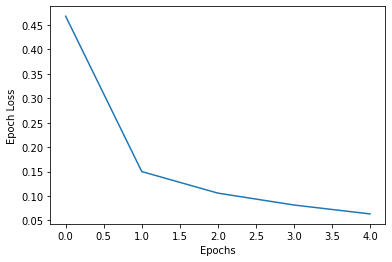

Validation Accuracy: 96.78571428571429



In [17]:
model = Model()

prevNodes = 784  # of the input layer (layer0)
currNodes = 100  # of the layer1
Z1 = Linear(prevNodes, currNodes)
model.add(Z1)

A1 = Relu()
model.add(A1)

currNodes = 10
prevNodes = 100
Z2 = Linear(prevNodes, currNodes)
model.add(Z2)

optimizer = SGD(model.parameters, alpha=1.0)
# optimizer = MomentumOptimizer(model.parameters, alpha = 1.0, momentum = 0.9)
# optimizer = AdaGrad(model.parameters, alpha = 1.0, epsilon = 10 ** -10)
# optimizer = RMSProp(model.parameters, alpha = 1.0, decay_rate = 0.9, epsilon = 10 ** -10)

lossFun = Multinomial()
batchSize = 100
epochs = 5

(X_train, Y_train), (X_test, Y_test) = loadMnist(0.2)

choice = input('0. first time\n1. use previous\n')
if choice == '0':
    model.train(X_train, Y_train, batchSize, epochs, optimizer, lossFun, 0)
elif choice == '1':
    model.train(X_train, Y_train, batchSize, epochs, optimizer, lossFun, 1)

model.evaluate(X_test, Y_test)

del model
